# Notebook 2: Working with Photometric Catalogs

In the last notebook, we demonstrated the basic concepts of producing a photometric catalog. In this notebook, we will learn how to work with data in photometric catalogs and extract information for scientific investigations.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

## Basic Information in a Catalog

In the following section we will go over some of the basic information one will need when working with any sort of photometric catalog. Every photometry file will have different column names but for the most part they all will have a unique ID for each source in the catalog, the coordinate of the source in RA and DEC and the flux of the source in many filters. The flux unit of the source varies form catalog to catalog and that information is typically contained within a file called the README file to outline what each of the column names are and what units the columns are in. Photometric catalogs can be composed of one telescope and telescopic instrument but sometimes some photometric catalogs can combine different measurements from different intruments into one catalog.

Let us explore the CEERS photometric catalog in the next few sections, which has a combination of JWST and HST data, and perform some analysis with it.

In [2]:
#reading in the CEERS Photometric information from the fits file
cat = fits.getdata('ceers_photom_v0.2.fits')

In [4]:
cat['D_APER'][0,:]

array([0.05      , 0.1       , 0.15000001, 0.2       , 0.30000001,
       0.40000001, 0.5       , 0.60000002, 0.80000001, 1.        ,
       1.41400003, 2.        ])

The catalog is stored in python as an Astropy table, which are similar to pandas DataFrame but they do have some unique differences.

Let's print out all the columns in the catalog

In [ ]:
cat.columns

This file has lots of columns but really we are only interested in a select few of them. Let us subselect the fluxes and magnitudes from this catalog

In [ ]:
#NOTE:  magnitude flux needs to be in Fnu units 

# Fluxes and Magnitudes

**Background**: It is important to go over what fluxes and magnitudes are and what the FXXXY refer to in the columns for FLUX and FLUXERR. On JWST, there are a bunch of filters that we astronomers can choose to look at. Imagine each filter as being a special pair of glasses that allows a very particular range of wavelengths to pass through. Below you can see what is called the filter response curve for all the JWST filters

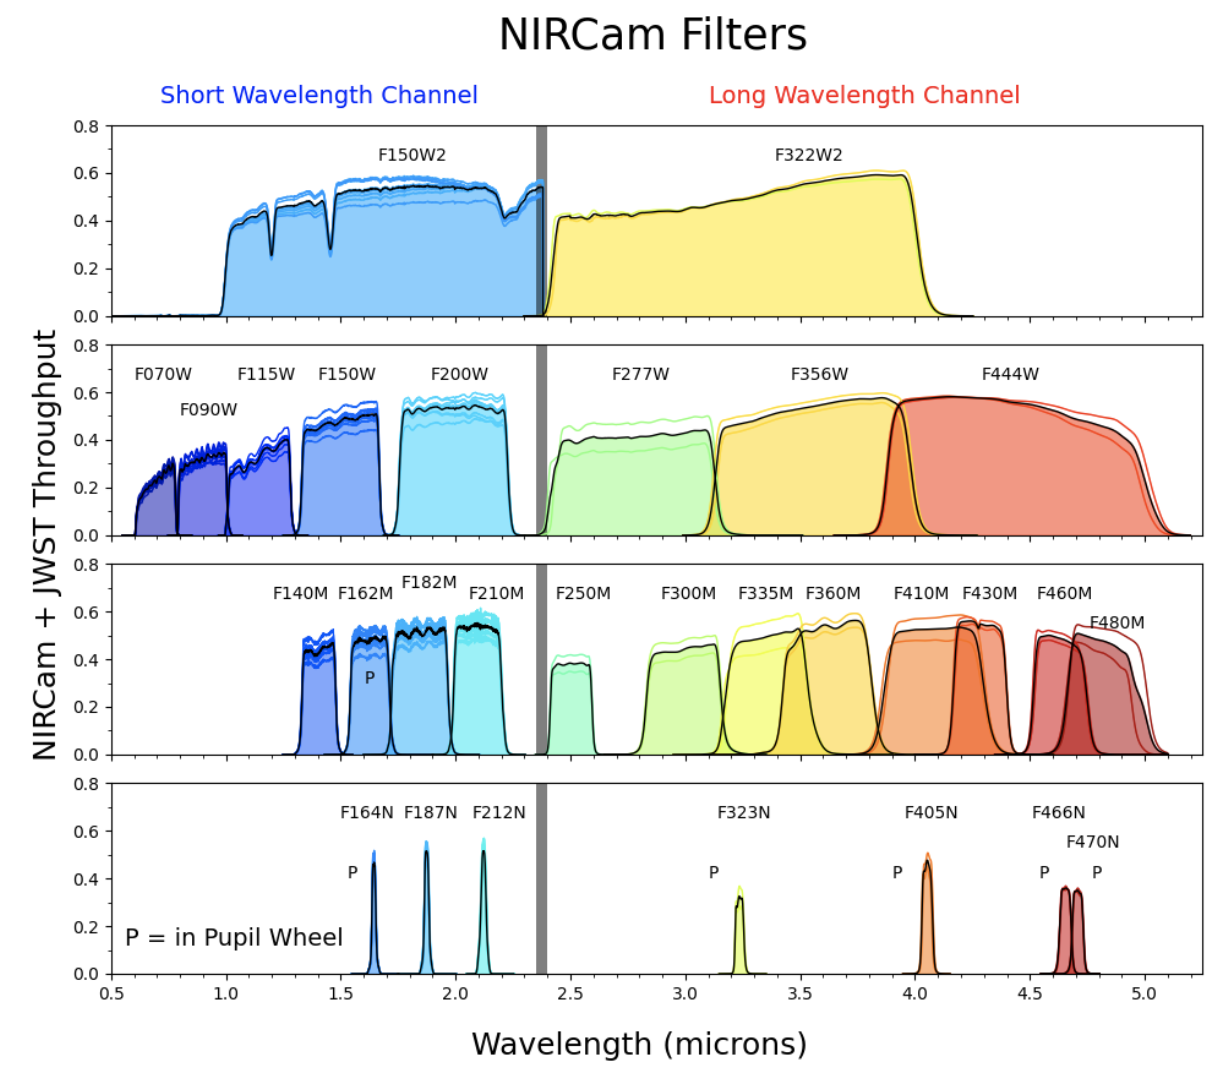

With each colored section showing the wavelength coverage that that particular filter spans over and the height of those filter response curves is how much of the light at each wavelength it is able to let through and detect with its detectors. When people work on photometric catalogs what they do is that they take an entire image of a patch of sky in a range of filters. In the case of CEERS they have observed the same patch of the sky using 7 filters: F115W, F150W, F200W, F277W, F356W, F410M, F444W. These filters only let light through that fall within the filter curves wavelength range and in the previous notebook you covered how we can use tools such as photutils to measure the flux of sources in a particular filter. We do the same procedure that you did in part 1 but for each filter giving us a flux measurement for every source at each filter. Once you have the flux of a source, in  $F_{\nu}$ units or i other words in units of $erg/s/cm^2/Hz$, it is relatively straight forward to compute the magnitude of the source using the following equation:

Mag = $-2.5log_{10}(Flux)$ + Zero_Point

**Note**: This Equation assumes that the flux you measured from your photometry is in units of $F_{\nu}$ or $erg/s/cm^2/Hz$


Where Flux is the flux you measured using your favorite photometric tool in $F_{\nu}$ units and the Zero_Point is a value that depends on which magnitude system you want to compute the magnitude for and what units your flux is in. Typically we will be working in a magnitude system called AB Magnitudes and the catalog you will be working on has the flux in units of nanoJansky and as a result the Zero_Point value will be 31.4. Check out the link below to see what the Zero_Point would be for a different $F_{\nu}$ scaling.

More info here: https://en.wikipedia.org/wiki/AB_magnitude

Let's read in the flux for one filter, the F115W Filter and compute the AB magnitude of it using the above equation.

In [ ]:
flux115 = cat['FLUX_F115W']

### Quick Note: 

**Fluxes in the CEERS Catalog are in nJy or nanoJansky.**

More info about what the unit of Jansky is can be found here: https://en.wikipedia.org/wiki/Jansky

Where 1 nanoJansky = $1\times10^{-9}$ Jansky and 1 Jansky = $1\times10^{-23}$ $erg/s/cm^2/Hz$

It is a very convenient unit when working in the AB Magnitude system as the AB magnitude system is derived from having a fixed flux of 3631 Jansky as the relative flux. Since the catalog fluxes are in nanoJansky that requires a bit of alteration to the magnitude equation to take this unit change into account and because of this that is why the zero point is 31.4 

In [ ]:
zpt = 31.4

In [ ]:
mag115 = -2.5 * np.log10(cat['FLUX_F115W']) + zpt

Let us now take the magnitude we have computed and plot up a histogram. This will produce what is called a magnitude distribution of all the sources in the catalog. 

Recall that with magnitudes the lower the number is the brighter the source is. We would typically expect that very bright sources would be very rare and very faint things much more common. Let us see what we get with the F115W filter.

In [ ]:
bins=np.linspace(15, 32)

plt.figure()

plt.hist(mag115, bins=bins, alpha=0.5)

plt.yscale('log')
plt.xlabel('F115W magnitude')
plt.ylabel('Number')

## So what happened?

At first glance it may seem like the Magnitude Distribution is doing what we think it is supposed to do but then it quickly turns over at around an AB Magnitude of 28.5 and the reason for that is because that is the Magnitude limit of the CEERS survey. If they were to expose JWST for longer it is possible for them to detect these fainter sources. Another complication that arises at these faint Magnitudes is that at these Magnitudes it is very hard to tell a real source from noise. 

# Exercise 1: Magnitude Distribution

**We kindly ask that you repeat the above calculation for the rest of the CEERS filter and generate a Magnitude distribution for the rest of the CEERS filters: F150W, F200W, F277W, F356W, F444W.**

Please label your plot with the filter and label your x and y axis, making sure to include the units when possible in your plots.

# The Importance of Significance

As we have seen above using the magntiude distribution is a great way to see how many sources there are per magnitude bin. However, as mentioned in the previous section, as we go to fainter object it becomes a lot more dificult to know if a source is real or if it a noise spike that mimics a real source. Luckily for us there is a way that we can figure out if a source is significant or not by using the signal-to-noise ratio. The signal-to-noise ratio (or S/N or SNR) is measured by taking the flux of the source and dividing it by the flux error, we then select a threshold and if a source is above this SNR threshold we say that this source is a real source and not a noise spike. Let us compute the SNR of sources in the CEERS F115W filter.

In [ ]:
#We take the flux and fluxerr of the F115W filter and divide them to get the SNR
sn115 = cat['FLUX_F115W'] / cat['FLUXERR_F115W']

In [ ]:
#plotting the SNR for the F115W filter as a function of magnitude
plt.figure()
plt.scatter(mag115, sn115, s=1)
plt.axhline(5, ls='--', color='k')
plt.xlim(25, 32)
plt.ylim(0, 20)

plt.xlabel('F115W magnitude')
plt.ylabel('S/N')

Using the above plot we can determine the $5\sigma$ flux limit of the F115W. But what does this $5\sigma$ flux limit mean and tell us. So when we compute the SNR we are actually determining how many standard deviations away from the noise the flux from this object is. Take for example that if we know the error of the flux is 1.2 then if we measure a flux value of 2.4 then we know that this flux value is 2 times or $2\sigma$ away from the typical noise flux value of 1.2. The $5\sigma$ flux limit is essentially telling us what is the minimum flux that is at *least* 5 times greater than the noise. 

So let us compute the $5\sigma$ flux limit of the F115W filter below. To do this we need to take a little window around SNR of 5, for the example below we will use a window of 0.2 around a SNR of 5.

In [ ]:
#.     Selecting SNR that are between 4.8 and 5.2 
sel = (sn115 > 4.8) & (sn115 < 5.2)

#Applying the mask to the variable holding the magnitude and then we take the median of this
lim115 = np.median(mag115[sel])
print('The 5 sigma flux limit of F115W is: {:.2f}'.format(lim115))

# Exercise 2: $5\sigma$ Magnitude Limit

**Compute the $5\sigma$ magnitude limit for the rest of the CEERS Filters: F150W, F200W, F277W, F356W, F444W.**

# Measuring Sizes of Galaxies

## 1. Half-light radius

Another column that this photometric catalog has is something called the half-light radius. This is the radius in which half of the light form the source is contained within. This is a very good diagnostic to determine the size of a galaxy as a galaxy who is bigger will have more of their light spread out and the half-light radius will be bigger than a galaxy which is more compact. The column name in this catalog that contains the half-light radius are the columns that start with RH_XXX where the XXX is the filters used to compute the half-light radius from. Let us take a look at the half light radius of sources in the F115W filter.

In [ ]:
#getting the Half-light radius of the F115W filter
rh = cat['RH_F115W']

In [ ]:

plt.figure()
plt.scatter(rh, mag115, s=1)
plt.xlabel('Half-Light Radius')
plt.ylabel('Magnitude [AB]')
plt.xlim(0, 10)
plt.ylim(30, 10)

# What do we see?

You may have noticed some few things when you plotted this up. One thing is that weird vertical track close to a half-light radius of 1. This vertical track is actually the track that point sources take in this diagram. So what is a point source, a point source are super tiny sources that do not have much spatial extent. They have a well defined characteristic in this diagram and can be easily selected

# Exercise 3: Half-Light Radius

**We kindly ask that you recreate the above plots for all the other CEERS Filters. Do you see any trend with Wavelength?**

## 2. Aperture Fluxes

Another way of measuring the size of a source is by using the aperture size. Recall from part 1 that we used the aperture to get the total flux of a galaxy. If the source is large and extended we would need a bigger aperture to capture it and therefore the aperture size would be bigger. Conversly, if a source was more compact, the aperture needed to get the total flux would be smaller. Thus, we can use the aperture size as a proxy for galaxy size.

To motivate this further, you may have heard a new population of gaalxies at high redshift being discovered called little red dots. These galaxies are compact sources and there was a paper in the literature that used the aperture size of these sources as a way to select these little red dots. 

In the photometric catalog there is a column called D_APER, this holds a two-dimensional array of Aperture diameters for each source. The row index is the index of the source and the column index is the diameter of the aperture used.

As such we can see how the flux of a source changes as the aperture size gets bigger for a given filter. 

In [ ]:
#code needed to generate the plots below. We will go over these in more detail in the Colors Section
mag150 = -2.5 * np.log10(cat['FLUX_F150W']) + zpt
mag200 = -2.5 * np.log10(cat['FLUX_F200W']) + zpt
mag277 = -2.5 * np.log10(cat['FLUX_F277W']) + zpt
mag444 = -2.5 * np.log10(cat['FLUX_F444W']) + zpt

#computing SNR ratio of all the filters to select good quality sources
sn150 = cat['FLUX_F150W']/ cat['FLUXERR_F150W'] 
sn200 = cat['FLUX_F200W']/ cat['FLUXERR_F200W'] 
sn277 = cat['FLUX_F277W']/ cat['FLUXERR_F277W'] 
sn356 = cat['FLUX_F356W']/ cat['FLUXERR_F356W'] 
sn444 = cat['FLUX_F444W']/ cat['FLUXERR_F444W'] 

sn_thresh = 5

#making a mask to mask out bad data and keep the good data
sig = (sn115 > sn_thresh) & (sn150 > sn_thresh) & (sn200 > sn_thresh) & \
        (sn277 > sn_thresh) & (sn356 > sn_thresh) & (sn444 > sn_thresh)

In [5]:
# Aperture diameters
cat['D_APER'][0,:]

array([0.05      , 0.1       , 0.15000001, 0.2       , 0.30000001,
       0.40000001, 0.5       , 0.60000002, 0.80000001, 1.        ,
       1.41400003, 2.        ])

In [ ]:
# Fluxes of different aperture radii
f444_02 = cat['FLUX_APERTOT_F444W'][:,5]
f444_04 = cat['FLUX_APERTOT_F444W'][:,8]

In [ ]:
f444_ratio = f444_04 / f444_02
# Ratio close to 1 means the source is compact, ratio > 1 means extended

In [ ]:
plt.figure()
plt.scatter(f444_ratio[sig], mag277[sig]-mag444[sig], s=1)
plt.xlim(0.5, 4)
plt.ylim(-1, 3)
plt.ylabel('F277W-F444W')
plt.xlabel('F444W(R=0.4") / F444W(R=0.2")')

plt.show()

# SED Plots

Photometric catalogs are the key piece of information that allow us to get a sense of the underlying stellar populations within galaxies due to the ease of acquiring imaging over spectroscopy. In the following section we will go over how to plot the Photometric points to reconstruct the SED or Spectral Energy Distribution of a galaxy. However, before we go into the nitty-gritty details of how to do that it is important to understand how we can use photometry to recreate the SED of a galaxy. 

In the beginning of this notebook there is a plot that shows the wavelength coverage for each filter. This means that only light that falls within this very specific wavelength window will be detected. So in a way we are getting **ALL** the light within this wavelength range from the galaxy. You can imaging if there are very strong emission lines that happen to fall within the wavelength range of a filter then the amount of flux we measure will be higher, due to emission line, than a galaxy that does not have an emission feature. So in a way we are getting an average flux of the galaxy within this wavelength range. In fact, the mathematical way of getting the average flux from a spectra with flux $F_{\lambda}$ through a filter curve $T_{\lambda}$ is: 

**Note: The below equation is used if your spectra is in $F_{\lambda}$ units or $erg/s/cm^2/Angstrom$**

$F_{avg}$ = $\frac{\int_{\lambda_1}^{\lambda_2}\lambda T_{\lambda} F_{\lambda} d\lambda}{\int_{\lambda_1}^{\lambda_2}\lambda T_{\lambda}d\lambda}$

**Note: The below equation is used if your spectra is in $F_{\nu}$ units or $erg/s/cm^2/Hz$**

$F_{avg}$ = $\frac{\int_{\nu_1}^{\nu_2}\frac{1}{\nu} T_{\nu} F_{\nu} d\nu}{\int_{\nu_1}^{\nu_2}\frac{1}{\nu} T_{\nu}d\nu}$

Most of the time when we plot spectra we plot them as a function of wavelength, so how would we plot the average flux if the filter covers a wide range of wavelength values? The answer to that is by using something called the central wavelength or effective wavelength. In essence what we are doing is we are getting the average wavelength and weighting it by the filter response curve. The formula for the central wavelength or the effective wavelength is:

$\lambda_{eff}$ = $\frac{\int_{\lambda_1}^{\lambda_2}\lambda T_{\lambda} d\lambda}{\int_{\lambda_1}^{\lambda_2}T_{\lambda} d\lambda}$

You can compute this yourself and we encourage you try this as an exercise but you can also look it up here: http://svo2.cab.inta-csic.es/theory/fps/

This website has all the filter response curve for a lot of many different telescopes and facilities. To see the central wavelengths for the NIRCAM filters click on the **JWST** tab and select **NIRCAM**, then you should see a table pop up listing all of the filters on NIRCAM. You can find the central wavelength under the $\lambda_{ref}$ column and note that these wavelengths are in Angstroms. We can then use this central wavelength and the flux in each filter to plot the SED of the galaxy. 

Let us see an example with the filters we have used so far.

In [ ]:
#making an array of central wavelengths, values taken from SVO and converted to microns
CENTRAL_WAVELENGTHS = np.array([
    1.154, 1.501, 1.989, 
    2.762, 3.568, 4.404,
])

#The filters we want to plot 
BANDS = [
    'F115W', 'F150W', 'F200W', 
    'F277W', 'F356W', 'F444W'
]

# Talk about SVO filters and getting the lambda_ref from there
# http://svo2.cab.inta-csic.es/theory/fps/

In [ ]:
def get_photometry(cat, idx, bands):
    
    '''
    Function that gets the photometry from a catalog given the catalog index and filters
    
    Inputs
    ----------
    cat: the photometric catalog
    idx: the index of the source we want to get photometry of
    bands: the filters we want to use
    
    Returns
    ------------
    flux: The flux of the source in the given bands
    fluxerr: The flux error of the source in the given bands
    '''
    
    flux = np.zeros(len(bands))
    fluxerr = np.zeros(len(bands))
    for i, b in enumerate(bands):
        flux[i] = cat[idx]['FLUX_{}'.format(b)]
        fluxerr[i] = cat[idx]['FLUXERR_{}'.format(b)]
    return flux, fluxerr


In [ ]:
# Get photometry for an object
flux, fluxerr = get_photometry(cat, 10, BANDS)

In [ ]:
#plotting the SED of the source
plt.figure()

plt.errorbar(CENTRAL_WAVELENGTHS, flux, yerr=fluxerr, color='k', fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux (nJy)')
plt.xlabel('Observed wavelength ($\mu$m)')

plt.tight_layout()
plt.show()

# Exercise 4: Plotting Full SED

In the above example we have shown how to plot the SED using only the CEERS filters but there are more filters in the photometric catalog. We encourage you to add the rest of the bands and plot the full SED for this source. This will involve changing BANDS and CENTRAL_WAVELENGTHS to include the other filters in the photometric catalog, namely: **F105W, F125W, F140W, F410M, F606W, F814W**. 

**Note**: The thing with filters is that they can come from different telescopes. So the combination of filters are a mix of **NIRCAM** from **JWST** and various instruments on **HST**. You can search for these filter by name if you type in the filter name in the search box on the top right of the SVO website. For example, if you type in **F105W** you will get one returned match, other filters will give back multiple matches. Like **F606W**, for example, if you were to type this into the search box this would return 8 matches. For **F606W** and the **F814W** please use the **ACS_WFC** filter.

# Colors

Colors are a unique way to understand the shape of a galaxy SED by taking the difference in magnitudes between different filters. Colors are computed by taking a red filter a subtracting from a blue filter:

Color = BLUE_FILTER_MAG - RED_FILTER_MAG

If it is positive we say that the galaxy is red since that would mean the magnitude in the blue filter is higher which would mean it is less luminous than the red filter and if it is negative we say that it is blue since that would mean the magnitude in the red filter is bigger which would mean it is fainter than the blue filter. Thus we can use colors to select for certain galaxies. For example, we would expect that star forming galaxies be really blue since they are undergoing lots of star formation and the light from a galaxy will be dominated by the hottest stars which shine brightest at the shortest wavelengths or shine brightest at bluer filters than in redder filters. Conversely we can select quiscent galaxies (galaxies that are no longer forming stars) by selecting very red colors as more of the light is becoming dominated by older stars which are most seen in redder wavelengths or redder filters. 

Let's apply some color selections to the CEERS Catalog.

In [ ]:
mag150 = -2.5 * np.log10(cat['FLUX_F150W']) + zpt
mag200 = -2.5 * np.log10(cat['FLUX_F200W']) + zpt
mag277 = -2.5 * np.log10(cat['FLUX_F277W']) + zpt
mag444 = -2.5 * np.log10(cat['FLUX_F444W']) + zpt

In [ ]:
#computing SNR ratio of all the filters to select good quality sources
sn150 = cat['FLUX_F150W']/ cat['FLUXERR_F150W'] 
sn200 = cat['FLUX_F200W']/ cat['FLUXERR_F200W'] 
sn277 = cat['FLUX_F277W']/ cat['FLUXERR_F277W'] 
sn356 = cat['FLUX_F356W']/ cat['FLUXERR_F356W'] 
sn444 = cat['FLUX_F444W']/ cat['FLUXERR_F444W'] 

sn_thresh = 5

#making a mask to mask out bad data and keep the good data
sig = (sn115 > sn_thresh) & (sn150 > sn_thresh) & (sn200 > sn_thresh) & \
        (sn277 > sn_thresh) & (sn356 > sn_thresh) & (sn444 > sn_thresh)



In [ ]:
plt.figure()
plt.scatter(mag444[sig], mag277[sig]-mag444[sig], s=1)
plt.xlim(18, 30)
plt.ylim(-1, 3)

plt.xlabel('F444W (mag)')
plt.ylabel('F277W-F444W (mag)')

In [ ]:
plt.figure()
plt.scatter(mag115[sig]-mag200[sig], mag277[sig]-mag444[sig], s=1)
plt.xlim(-3, 4)
plt.ylim(-1, 3)

plt.xlabel('F115W-F200W')
plt.ylabel('F277W-F444W')

## Matching Two Catalogs

Cross matching catalogs is somethign astronomers do almost everyday. In this section we will cross match the CEERS catalog to another catalog and see if there are any differences in flux between the two catalog looking at the same patch of the sky.

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [ ]:
#reading in the catalog to cross match
cat_h = fits.getdata('hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1-1photom_cat.fits')

In [ ]:
cat_h.columns

In [ ]:
#getting the RA and DEC for CEERS
ra_ceers = cat['RA']
dec_ceers = cat['DEC']

#getting the RA and DEC from the other catalog
ra_candels = cat_h['RA']
dec_candels = cat_h['DEC']

In [ ]:
#making SkyCoord Objects
coords_ceers = SkyCoord(ra=ra_ceers, dec=dec_ceers, unit=u.deg)
coords_candels = SkyCoord(ra=ra_candels, dec=dec_candels, unit=u.deg)

In [ ]:
#matching ceers to candels
idx, d2d, d3d = coords_ceers.match_to_catalog_sky(coords_candels)

# Note:

idx: is the index location **in the candels** catalog that is the closest match to the ceers catalog

d2d: is the on sky separation

d3d: is the 3D separation but since we did not provide it a redshift array this is not accurate and we will omit

In [ ]:
d2d

In [ ]:
d2d.to(u.arcsec)

# Figuring out Separation Threshold

In [ ]:
plt.figure()
plt.hist(d2d.to(u.arcsec).value, bins=np.linspace(0,1))
plt.xlabel('Offset (arcsec)')
plt.ylabel('Number')
plt.show()

In [ ]:
# Pick a reasonable threshold from plot above
good_match = d2d < 0.2 * u.arcsec

In [ ]:
#We mask out the indexes that were too far
idx_gm = idx[good_match]

## Compare two similar bands between HST in CANDELS and JWST in CEERS

Below we will go over how to compare similar filters between CANDELS and CEERS. Note that since they do not have the same filters we cannot do a direct comparison but the F150W filter in CEERS is similar to the F160W filter in CANDELS.

In [ ]:
f150 = cat['FLUX_F150W']
f160 = cat_h['WFC3_F160W_FLUX'] * 1000 # Note CANDELS fluxes are in uJy, but CEERS fluxes are in nJy

In [ ]:
f150_match = f150[good_match]

In [ ]:
f160_match = f160[idx_gm]

In [ ]:
mag_f150_match = -2.5 * np.log10(f150_match) + zpt

In [ ]:
plt.figure()
plt.scatter(mag_f150_match, (f160_match-f150_match)/f150_match, s=1)
#plt.yscale('log')
plt.axhline(0, ls='--', color='k')
plt.ylim(-1, 1)

plt.xlabel('F150W mag')
plt.ylabel('$\Delta$ Flux / F150W')
